# Comparison of bot performance for different game configurations
In this notebook we want to find out the optimal number of games for the benchmarking of the agents and explore the differences of the bot performances for different game configurations (board size and number of colors)

In [1]:
from samegamerl.evaluation.benchmark_scripts import benchmark_builtin_bots
from samegamerl.game.game_config import GameFactory
import matplotlib.pyplot as plt
import math


/Users/patrick/Library/Caches/pypoetry/virtualenvs/samegamerl-uM3J679_-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-29 17:53:17,276	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Find optimal number of games
First we will plot the matrics for all three built-in bots to see how quickly the cumulative metrics (i.e. how many tiles on average are left on the board) converge to a stable value. This will help us determine on how many games we should evaluate agents to get a good sense of their actual performance.

Running benchmark with 10,000 games...
RandomBot: Using existing results for all 10000 games
LargestGroupBot: Using existing results for all 10000 games
GreedySinglesBot: Using existing results for all 10000 games
Processed statistics for 100 different game counts


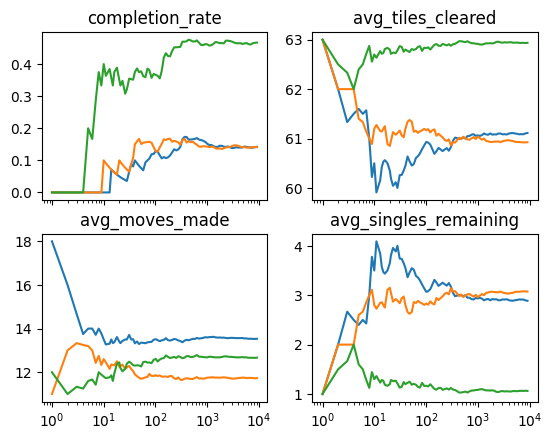

In [6]:
from samegamerl.evaluation.benchmark import Benchmark
from samegamerl.evaluation.benchmark_scripts import _compute_stats
from samegamerl.game.game_config import GameFactory
import matplotlib.pyplot as plt
import math

def compute_cumulative_stats(results: dict[str, list], num_games: int) -> dict[str, dict[str, float]]:
    """Compute performance statistics for the first num_games from benchmark results."""
    subset_results = {}
    for bot_name, performances in results.items():
        if performances and len(performances) >= num_games:
            subset_results[bot_name] = performances[:num_games]
    
    return _compute_stats(subset_results)

max_games = 10_000 

print(f"Running benchmark with {max_games:,} games...")

# Create benchmark with Ray CPU limit to prevent system freeze
# Use 6 out of 10 available CPU cores, leaving 4 for system operations
benchmark = Benchmark(
    config=GameFactory.medium(), 
    num_games=max_games,
    use_ray=True,
    ray_num_cpus=6  # Limit Ray to 6 CPU cores instead of all 10
)

raw_results = benchmark.run_bots(benchmark.built_in_bots())

game_nums = []
stats = []

n = 100
base = max_games**(1/100)
for i in range(n):
    game_num = math.ceil(base**i)
    game_nums.append(game_num)
    
    # Compute cumulative statistics for this game count
    cumulative_stats = compute_cumulative_stats(raw_results, game_num)
    stats.append(cumulative_stats)

# Reverse to match original order
stats.reverse()
game_nums.reverse()

print(f"Processed statistics for {len(game_nums)} different game counts")

# Restore the original plotting code
bots = list(stats[0].keys())
metrics = list(stats[0][bots[0]].keys())
results = {}
for metric in metrics:
    results[metric] = {}
    for bot in bots:
        results[metric][bot] = []
for stat in stats:
    for bot in bots:
        for metric in metrics:
            results[metric][bot].append(stat[bot][metric])

fig, axs = plt.subplots((len(metrics)+1)//2, 2, sharex=True)
for i in range(len(metrics)):
    for bot in bots:
        axs[i//2, i % 2].semilogx(game_nums, results[metrics[i]][bot], label=bot)
    axs[i//2, i % 2].set_title(metrics[i])